In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_points_min_curve(file):
    ident = open(file)
    x = []
    y = []
    z = []
    while True:
        line = ident.readline()

        if not line:
            break
            
        words = line.split(',', 3)
        print
        
        word_1 = words[0].split(':')
        word_2 = words[1].split(':')
        word_3 = words[2].split(':')

        x.append(float(word_1[2]))
        y.append(float(word_2[1]))
        z.append(float(word_3[1]))

    return x, y, z


In [3]:
def get_points_d(file):
    ident = open(file)
    x = []
    y = []
    z = []

    while True:
        line = ident.readline()
        if not line:
            break

        words = line.split(':')

        if len(words) == 3:
            x.append(float(words[2]))
        elif float(words[1]) == 0:
            z.append(float(words[1]))
        else:
            y.append(float(words[1]))

    return x, y, z

In [4]:
file_name = 'delauney_points.txt'
x, y, z = get_points_d(file_name)


In [5]:
file_name_2 = 'points.txt'
x_2, y_2, z_2 = get_points_min_curve(file_name_2)

In [6]:
def get_cones(file):
    ident = open(file)
    x = []
    y = []

    while True:
        line = ident.readline()
        if not line:
            break

        words = line.split(',')
        length = len(words)

        for i in range(length):
            if i%2 == 0:
                pos_x = words[i].find('(')
                #print(words[i][pos_x + 1 :])
                x.append(float(words[i][pos_x + 1 :]))
            else:
                pos_y = words[i].find(')')
                y.append(float(words[i][:pos_y]))

    return x, y

In [7]:
def get_combined_cones(file):
    ident = open(file)
    x = []
    y = []

    while True:
        line = ident.readline()
        if not line:
            break

        words = line.split(',', 2)
        
        pos_x = words[0].find('[')
        x.append(float(words[0][pos_x+1:].strip()))
        pos_y = words[1].find(']')
        y.append(float(words[1][:pos_y].strip()))

    return x, y

In [8]:
yellow_cone_file = 'yellow_cones.txt'
yellow_cone_x, yellow_cone_y = get_cones(yellow_cone_file)

blue_cone_file = 'blue_cones.txt'
blue_cone_x, blue_cone_y = get_cones(blue_cone_file)

In [9]:
combined_cone = 'combined_cones.txt'
combined_cone_x, combined_cone_y = get_combined_cones(combined_cone)

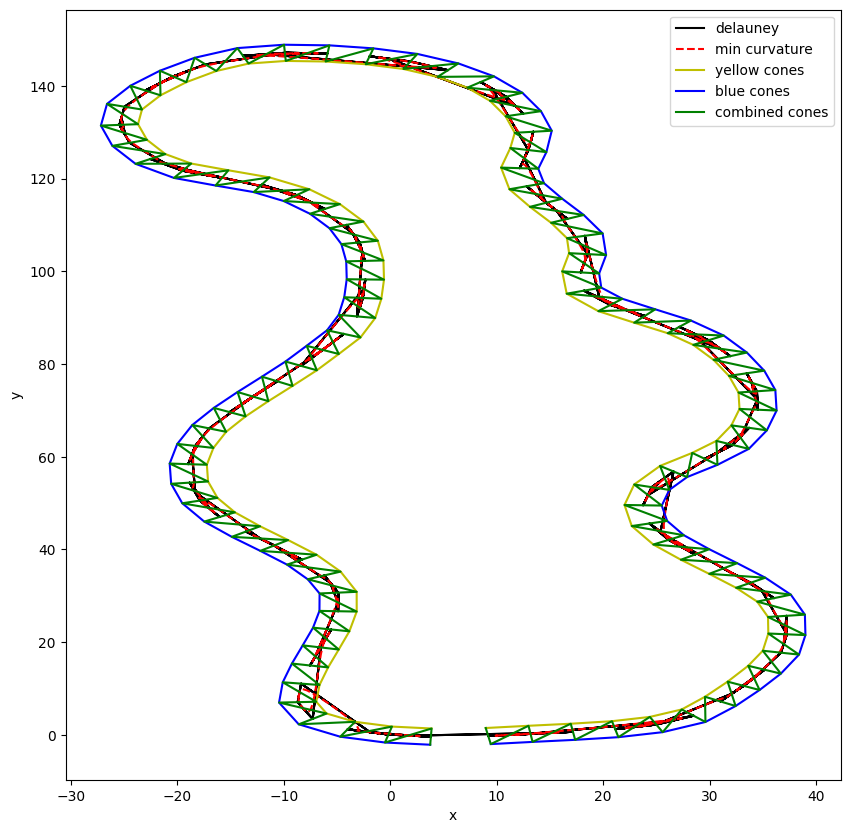

In [10]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, '-k', label='delauney')
plt.plot(x_2, y_2, 'r--', label='min curvature')
plt.plot(yellow_cone_x, yellow_cone_y, '-y', label='yellow cones')
plt.plot(blue_cone_x, blue_cone_y, '-b', label='blue cones')
plt.plot(combined_cone_x, combined_cone_y, '-g', label='combined cones')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


In [13]:
import math
track_width = np.sqrt((np.array(yellow_cone_x) - np.array(blue_cone_x))**2 + (np.array(yellow_cone_y) - np.array(blue_cone_y))**2)
min_track_width = np.min(track_width)

[3.50000087 3.49999286 3.50000809 3.50000764 3.50000454 3.49999824
 3.50000148 3.5000051  3.50000199 3.50000396 3.49999832 3.50000125
 3.49999937 3.49999957 3.49999891 3.50000184 3.50000194 3.49999807
 3.49999659 3.50000178 3.5000033  3.4999977  3.50000189 3.49999728
 3.50000098 3.50000227 3.49999702 3.5000033  3.49999679 3.4999971
 3.4999976  3.50000861 3.50000124 3.49999578 3.50000035 3.50000602
 3.49999792 3.50000552 3.49999852 3.50000478 3.50000214 3.49999861
 3.49999609 3.49999787 3.49999849 3.49998993 3.50001503 3.50001196
 3.49999528 3.50000012 3.49999872 3.50000295 3.49999873 3.4999926
 3.50000054 3.49999879 3.50000295 3.49999562 3.4999962  3.49999101
 3.49999579 3.49999227 3.49999862 3.50000423 3.50000178 3.49999874
 3.50000336 3.49999987 3.49999947 3.49999658 3.49999563 3.49999753
 3.50000364 3.50000106 3.4999973  3.50000115 3.50000067 3.49999723
 3.49999965 3.5000017  3.50000035 3.49999977 3.49999919 3.50000116
 3.49999672 3.50000235 3.5000026  3.49999983 3.50000215 3.499999

In [ ]:
def filter_path(ref_path, state):
    min_dist = 1000000
    min_index = 0
    for i in range(len(ref_path)):
        dist = (ref_path[i][0] - state[0])**2 + (ref_path[i][1] - state[1])**2
        if dist < min_dist:
            min_dist = dist
            min_index = i

    return ref_path[min_index]

In [30]:
def find_cross_track_error(ref_path, state, min_track_width):
    # Find the nearest point on the path
    max_deviation = min_track_width/2
    min_dist = 1000000
    min_index = 0
    for i in range(len(ref_path)):
        dist = (ref_path[i][0] - state[0])**2 + (ref_path[i][1] - state[1])**2
        if dist < min_dist:
            min_dist = dist
            min_index = i

    # Find the cross track error
    if min_index == 0:
        min_index += 1
    elif min_index == len(ref_path) - 1:
        min_index -= 1

    x1 = ref_path[min_index - 1][0]
    y1 = ref_path[min_index - 1][1]
    x2 = ref_path[min_index][0]
    y2 = ref_path[min_index][1]
    x3 = state[0]
    y3 = state[1]
    cross_track_error = (y2 - y1) * x3 - (x2 - x1) * y3 + x2 * y1 - y2 * x1
    cross_track_error /= math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

    normalized_cross_track_error = cross_track_error / max_deviation

    return normalized_cross_track_error 

(768, 2)


In [72]:
cte_yellow = []
ref_id = []
for i in range(11):
    cte ,  index = find_cross_track_error(ref_path, np.array([yellow_cone_x[i], yellow_cone_y[i]]))
    cte_yellow.append(cte)
    ref_id.append(index)

print(cte_yellow)
print(ref_path[ref_id])

[1.7497620580954614, 1.7499943674293261, -1.7499613915892427, 1.7444997784544176, -1.741631316943531, -1.7189400593682889, 1.7492157277297844, -1.7488645821363265, -1.7491732303390726, -1.7167649708142627, 1.740151779367895]
[[ 9.20541504 -0.23991211]
 [13.17512207  0.23595703]
 [17.15748535  0.68086914]
 [21.12257813  1.24019531]
 [24.9795752   2.24257568]
 [28.48324707  4.14546387]
 [30.99189941  7.23574219]
 [33.17841309 10.59092773]
 [35.14519043 14.06848633]
 [36.68063965 17.74332031]
 [37.24087402 21.70419922]]


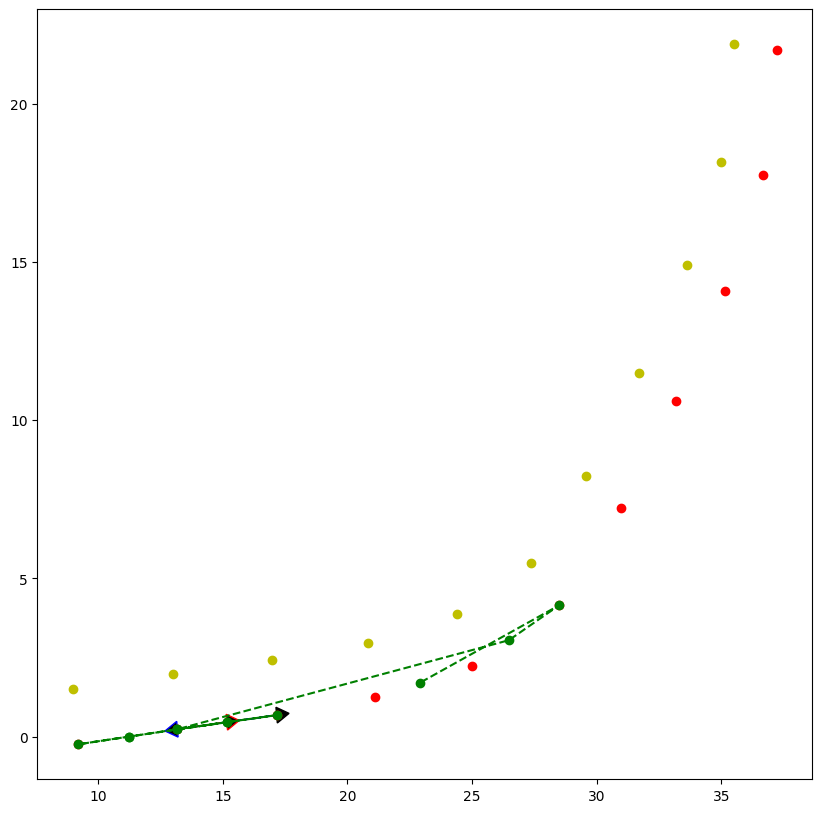

In [62]:
plt.figure(figsize=(10, 10))
plt.plot(yellow_cone_x[:11], yellow_cone_y[:11], 'oy', label='yellow cones')
plt.plot(ref_path[ref_id][:,0], ref_path[ref_id][:,1], 'or', label='reference path')
plt.plot(ref_path[:11, 0], ref_path[:11, 1], '--og', label='reference path')
plt.arrow(ref_path[0, 0], ref_path[0, 1], ref_path[1, 0] - ref_path[0, 0], ref_path[1, 1] - ref_path[0, 1], head_width=0.5, head_length=0.5, fc='k', ec='k')
plt.arrow(ref_path[1, 0], ref_path[1, 1], ref_path[2, 0] - ref_path[1, 0], ref_path[2, 1] - ref_path[1, 1], head_width=0.5, head_length=0.5, fc='k', ec='b')
plt.arrow(ref_path[2, 0], ref_path[2, 1], ref_path[3, 0] - ref_path[2, 0], ref_path[3, 1] - ref_path[2, 1], head_width=0.5, head_length=0.5, fc='k', ec='r')

In [57]:
ref_path[:10]

array([[ 1.51588916e+01,  4.57568359e-01],
       [ 1.71574854e+01,  6.80869141e-01],
       [ 1.31751221e+01,  2.35957031e-01],
       [ 1.51588916e+01,  4.57568359e-01],
       [ 1.12129565e+01,  8.20312500e-04],
       [ 9.20541504e+00, -2.39912109e-01],
       [ 1.12129565e+01,  8.20312500e-04],
       [ 1.31751221e+01,  2.35957031e-01],
       [ 2.64767578e+01,  3.04799316e+00],
       [ 2.84832471e+01,  4.14546387e+00]])

In [77]:
cte_yellow_ = []
ref_id_ = []
for i in range(len(yellow_cone_x)):
    cte ,  index = find_cross_track_error(ref_path, np.array([yellow_cone_x[i], yellow_cone_y[i]]))
    cte_yellow_.append(cte)
    ref_id_.append(index)


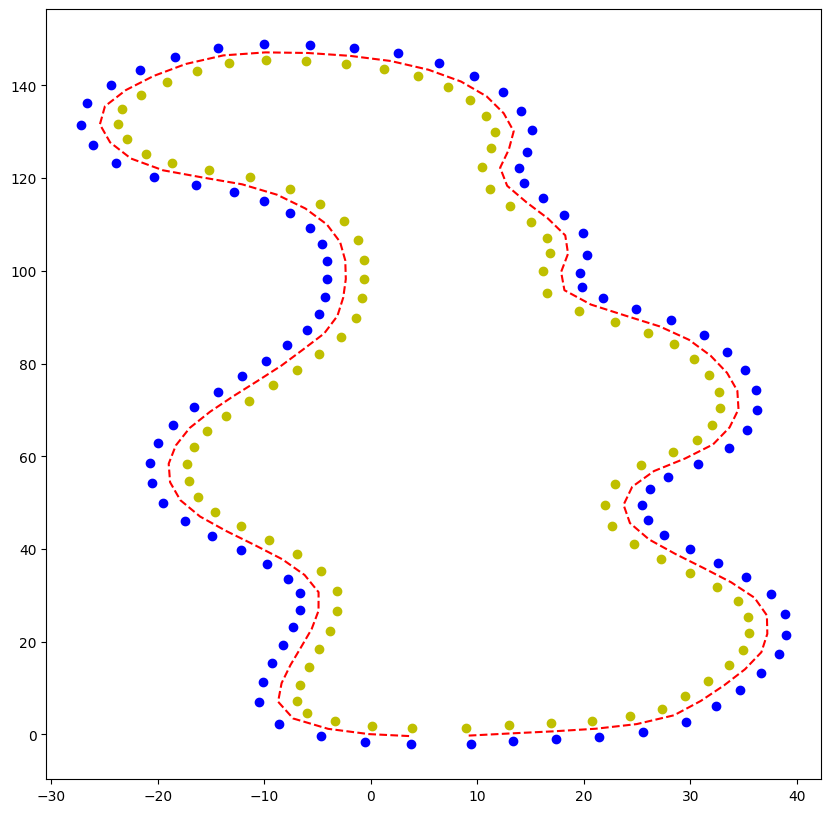

In [80]:
plt.figure(figsize=(10, 10))
plt.plot(yellow_cone_x, yellow_cone_y, 'oy', label='yellow cones')
plt.plot(ref_path[ref_id_][:,0], ref_path[ref_id_][:,1], '--r', label='reference path')
plt.plot(blue_cone_x, blue_cone_y, 'ob', label='blue cones')

In [84]:
len(yellow_cone_x)


96

[1.7497620580954614,
 1.7499943674293261,
 -1.7499613915892427,
 1.7444997784544176,
 -1.741631316943531,
 -1.7189400593682889,
 1.7492157277297844,
 -1.7488645821363265,
 -1.7491732303390726,
 -1.7167649708142627,
 1.740151779367895,
 -1.7208491762670368,
 1.7334478389350119,
 1.7490696873664855,
 -1.7496844047721347,
 1.7487982155869624,
 -1.7469378645717757,
 -1.7305881142110267,
 1.7256819472475444,
 -1.7344052296297343,
 -1.3759372371662097,
 1.739748183550443,
 -1.7164879376338498,
 -1.7158159374432649,
 1.7359224310042367,
 1.7427513971332274,
 -1.7443990253375108,
 1.7456020943364436,
 1.7299763330185756,
 -1.734758559174735,
 1.749088063612953,
 -1.7459951246326817,
 -1.6799248838274132,
 1.7491186661806812,
 1.7212885495676211,
 -1.7176311419017107,
 1.749575675872091,
 -1.7500027204478101,
 -1.7430896477341014,
 1.734769426389428,
 -1.7477125114298482,
 -1.7010957514531617,
 1.742622011013849,
 1.7354829505672171,
 -1.7355059177304941,
 1.7406763019723075,
 1.740928335009642